# H.O.G. and SVM Image Classification with OpenCV and Computer Vision Studio

## Import Important Libraries and Define Auxilary Functions


Libraries for data processing and visualization:


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime

Libraries for image pre-processing and classification:


In [2]:
import cv2
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

Libraries for OS and Cloud:


In [3]:
import os
from skillsnetwork import cvstudio

We will load and process every image. Let's go over some concepts:

<ul>
        <ul>
            <li><code>cv2.resize()</code> to resize the image </li>
            <li><code>cv2.COLOR_BGR2GRAY()</code> will convert the images to greyscale image</li>
            <li><code>hog()</code> will get the H.O.G. features from the image </li>
        </ul>
    
</ul>

We will use this function to read and preprocess the images, the function will be explained in the **Histogram of Oriented Gradients (H.O.G.)** section.


In [4]:
def load_images(image_paths):
# loop over the input images
    for (i, image_path) in enumerate(image_paths):
        #read image
        image = cv2.imread(image_path)
        image = np.array(image).astype('uint8')
        image = cv2.resize(image, (64, 64))
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hog_features, hog_images = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
        #label image using the annotations
        label = class_object.index(annotations["annotations"][image_path[7:]][0]['label'])
        train_images.append(hog_features)
        train_labels.append(label)


## Download Images and Annotations


In [5]:
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()

# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 400/400 [01:35<00:00,  4.18it/s]


In [6]:
annotations = cvstudioClient.get_annotations()

In [7]:
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five

{'7b951b8b-0ace-4b13-9b8c-fbcea3738d0e.jpg': [{'label': 'cat'}],
 'a2137508-12dc-4f41-b483-442b12f3712a.jpg': [{'label': 'dog'}],
 '1d4b3aa2-0745-49ef-91cb-b82c2e7040c3.jpg': [{'label': 'dog'}],
 '02f3b4fe-9876-41a8-88de-773d5372ffad.jpg': [{'label': 'dog'}],
 'e2d22403-01c3-46e3-b10a-4c1586b68aa0.jpg': [{'label': 'cat'}]}

## Histogram of Oriented Gradients (H.O.G.)


H.O.G. generates a histogram for each localized region.


In [8]:
sample_image = 'images/' + random.choice(list(annotations["annotations"].keys()))

In [9]:
sample_image = cv2.imread(sample_image)

In [10]:
sample_image = cv2.resize(sample_image, (64, 64))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)

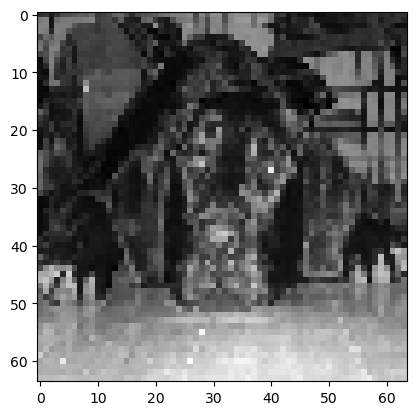

In [11]:
plt.imshow(sample_image, cmap=plt.cm.gray)

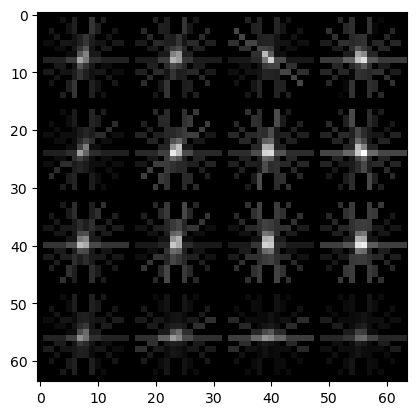

In [12]:
## when we run H.O.G., it returns an array of features and the image/output it produced
## the featurre is what we use to train the SVM model
sample_image_features, sample_hog_image = hog(sample_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

## lets look at what the H.O.G. feature looks like
plt.imshow(sample_hog_image, cmap=plt.cm.gray)

## Load Images and Generate Training/Testing Dataset


In [13]:
image_paths = list(paths.list_images('images'))
train_images = []
train_labels = []
class_object = annotations['labels']

In [14]:
load_images(image_paths)

In [15]:
train_array = np.array(train_images)
train_array = np.vstack(train_array)

In [16]:
labels_array = np.array(train_labels)

In [17]:
labels_array = labels_array.astype(int)
labels_array = labels_array.reshape((labels_array.size,1))

In [18]:
train_df = np.concatenate([train_array, labels_array], axis = 1)

In [19]:
percentage = 75
partition = int(len(train_df)*percentage/100)

In [20]:
x_train, x_test = train_df[:partition,:-1],  train_df[partition:,:-1]
y_train, y_test = train_df[:partition,-1:].ravel(), train_df[partition:,-1:].ravel()

## Hyperparameters


In [21]:
param_grid = {'kernel': ('linear', 'rbf'),'C': [1, 10, 100]}

## Support Vector Machines


In [22]:
base_estimator = SVC(gamma='scale')

In [23]:
start_datetime = datetime.now()
start = time.time()

svm = GridSearchCV(base_estimator, param_grid, cv=5)
#Fit the data into the classifier
svm.fit(x_train,y_train)
#Get values of the grid search
best_parameters = svm.best_params_
print(best_parameters)
#Predict on the validation set
y_pred = svm.predict(x_test)
# Print accuracy score for the model on validation  set. 
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))

end = time.time()
end_datetime = datetime.now()
print(end - start)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

{'C': 100, 'kernel': 'rbf'}
Accuracy: 0.86
1.2202506065368652


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:821: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Get Confusion Matrix for SVM results:


In [24]:
label_names = [0, 1]
cmx = confusion_matrix(y_test, y_pred, labels=label_names)

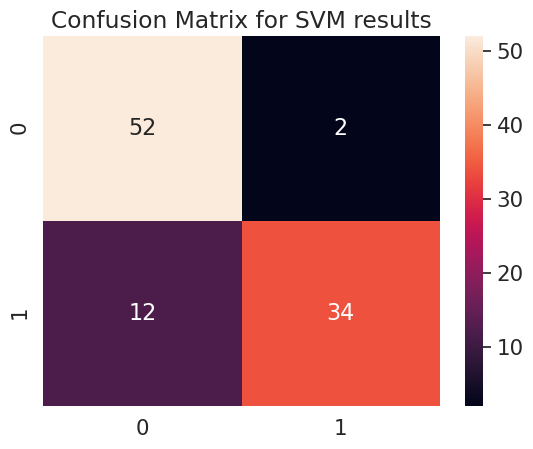

In [25]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

## Let's Report Our Results Back to CV Studio


In [ ]:
parameters = {
    'best_params': best_parameters
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy=accuracy_score(y_test, y_pred))

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

In [ ]:
# Save the SVM model to a file
joblib.dump(svm.best_estimator_, 'svm.joblib')

In [ ]:
# Now let's save the model back to CV Studio
result = cvstudioClient.uploadModel('svm.joblib', {'svm_best': svm.best_estimator_})